In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import copy
import time
import os
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

mat = loadmat("Data_01.mat")
df_Train = pd.DataFrame(mat["Training"])
df_Test = pd.DataFrame(mat["Testing"])

Train = df_Train.values
Test = df_Test.values

In [2]:
def load_Dataset(Train, Test):
    x_train = Train[:, 0:-1]
    y_train = Train[:, -1]

    x_test = Test[:, 0:-1]
    y_test = Test[:, -1]
    if False:
        y_train = np.expand_dims(y_train, axis = 1)
        y_train = np.hstack((y_train, (1 - y_train)))
        y_test = np.expand_dims(y_test, axis = 1)
        y_test = np.hstack((y_test, (1 - y_test)))

    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    
    return x_train, y_train, x_test, y_test

def my_pca(x_train, x_test, k):
    x_train_mean = torch.mean(x_train, dim = 0)
    x_train_reduced = x_train - x_train_mean

    Sigma = torch.mm(x_train_reduced.t(), x_train_reduced) / len(x_train_reduced)

    u, s, v = torch.svd(Sigma)
    score = torch.sum(s[0:k]) / torch.sum(s)
    u_reduced = u[:, 0:k]
    
    x_train_reduced = torch.mm(x_train_reduced, u_reduced)
    
    x_test_mean = torch.mean(x_test, dim = 0)
    x_test_reduced = x_test - x_test_mean

    x_test_reduced = torch.mm(x_test_reduced, u_reduced)
    return x_train_reduced, x_test_reduced, score

# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], num_classes)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) 
        a_2 = F.relu(self.fc2(a_1))
        y_pred = self.fc3(a_2)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred
    
    
def train_model(pca_bool = False, pca_num = 10):
    # Load Dataset
    x_train, y_train, x_test, y_test = load_Dataset(Train, Test)
    score = 100
    if pca_bool:
        x_train, x_test, score = my_pca(x_train, x_test, pca_num)
    # Device configuration
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    # Model configuration
    [m_train, n_train] = x_train.shape
    input_size = n_train
    hidden_size = [60, 30] 
    num_classes = 2
    # Train configuration
    num_epochs = 3000
    learning_rate = 0.01
    dropout_p = 0.5
    step_size = 500
    
    model = MLP(input_size = input_size, 
               hidden_size = hidden_size,
                num_classes = num_classes)

    model = model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    
    # Optimization
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=0.5)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Training
    for t in range(num_epochs):

        scheduler.step()
        # Forward pass
        y_pred = model(x_train)

        # Accuracy
        _, predictions = y_pred.max(dim = 1)
        accuracy = get_accuracy(y_pred = predictions.long(), y_target = y_train)

        # Loss
        loss = loss_fn(y_pred, y_train)


        # Verbose
        if t%10==0: 
            _, pred_test = model(x_test, apply_softmax=True).max(dim=1)
            test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
            # deep copy the model
            if test_acc > best_acc:
                best_acc = test_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if t%500 == 0:
                print ("epoch: {0:4d} | loss: {1:.4f} | Train accuracy: {2:.1f}% | Test accuracy: {3:.1f}%" \
                       .format(t, loss, accuracy, test_acc))

        # Zero all gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    
        # Predictions
    _, pred_train = model(x_train, apply_softmax=True).max(dim=1)
    _, pred_test = model(x_test, apply_softmax=True).max(dim=1)

    # Train and test accuracies
    train_acc = get_accuracy(y_pred = pred_train, y_target=y_train)
    test_acc = get_accuracy(y_pred = pred_test, y_target=y_test)
    print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

    y_true = y_test.cpu().numpy()
    y_pred = pred_test.cpu().numpy()

    cm_perf = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    print(report)
    acc = (cm_perf[1, 1] + cm_perf[0, 0]) / np.sum(cm_perf)
    recall = cm_perf[1, 1] / (cm_perf[1, 0] + cm_perf[1, 1])
    precision = cm_perf[1, 1] / (cm_perf[0, 1] + cm_perf[1, 1])
    score = 2 / ((1 / recall) + (1 / precision))
    model_perf = torch.tensor([acc, precision, recall, score])
    
    return model, model_perf

In [3]:
model, model_perf = train_model(pca_bool = False, pca_num = 10)

epoch:    0 | loss: 0.7329 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1196 | Train accuracy: 94.0% | Test accuracy: 81.6%
epoch: 1000 | loss: 0.1145 | Train accuracy: 94.4% | Test accuracy: 85.4%
epoch: 1500 | loss: 0.1127 | Train accuracy: 94.4% | Test accuracy: 85.1%
epoch: 2000 | loss: 0.1117 | Train accuracy: 94.5% | Test accuracy: 85.4%
epoch: 2500 | loss: 0.1113 | Train accuracy: 94.5% | Test accuracy: 85.4%
Training complete in 0m 23s
train acc: 93.9%, test acc: 86.9%
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     37000
           1       0.84      0.94      0.89     45332

   micro avg       0.87      0.87      0.87     82332
   macro avg       0.88      0.86      0.86     82332
weighted avg       0.87      0.87      0.87     82332



# PCA

In [4]:
x_train, y_train, x_test, y_test = load_Dataset(Train, Test)
num = x_train.size(1)
flag = 1
for i in range(num):
    _, _, score = my_pca(x_train, x_test, i)
    if score < 0.9:
        continue
    else:
        print(("-" * 30) + "pca: {0:3d}".format(i) + ("-" * 30))
        model, perf = train_model(pca_bool= True, pca_num= i)
        path = str(i) + ".pt"
        torch.save(model, path)
        perf = torch.unsqueeze(perf, dim = 0)
        if flag == 1:
            model_perf = perf
            flag = 2
        else: 
            model_perf = torch.cat((model_perf, perf), 0)

------------------------------pca:   9------------------------------
epoch:    0 | loss: 0.6643 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1405 | Train accuracy: 93.4% | Test accuracy: 81.0%
epoch: 1000 | loss: 0.1378 | Train accuracy: 93.4% | Test accuracy: 81.1%
epoch: 1500 | loss: 0.1364 | Train accuracy: 93.5% | Test accuracy: 81.0%
epoch: 2000 | loss: 0.1354 | Train accuracy: 93.6% | Test accuracy: 80.9%
epoch: 2500 | loss: 0.1349 | Train accuracy: 93.6% | Test accuracy: 80.8%
Training complete in 0m 20s
train acc: 93.4%, test acc: 81.1%
              precision    recall  f1-score   support

           0       1.00      0.58      0.73     37000
           1       0.74      1.00      0.85     45332

   micro avg       0.81      0.81      0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.86      0.81      0.80     82332

------------------------------pca:  10------------------------------


/home/johnpaul/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:    0 | loss: 0.6458 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1372 | Train accuracy: 93.7% | Test accuracy: 81.1%
epoch: 1000 | loss: 0.1343 | Train accuracy: 93.7% | Test accuracy: 81.2%
epoch: 1500 | loss: 0.1326 | Train accuracy: 93.8% | Test accuracy: 81.2%
epoch: 2000 | loss: 0.1316 | Train accuracy: 93.8% | Test accuracy: 81.1%
epoch: 2500 | loss: 0.1309 | Train accuracy: 93.9% | Test accuracy: 81.2%
Training complete in 0m 20s
train acc: 93.6%, test acc: 82.2%
              precision    recall  f1-score   support

           0       0.97      0.62      0.76     37000
           1       0.76      0.99      0.86     45332

   micro avg       0.82      0.82      0.82     82332
   macro avg       0.87      0.80      0.81     82332
weighted avg       0.86      0.82      0.81     82332

------------------------------pca:  11------------------------------
epoch:    0 | loss: 0.6319 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.13

epoch: 1000 | loss: 0.1172 | Train accuracy: 94.2% | Test accuracy: 82.1%
epoch: 1500 | loss: 0.1152 | Train accuracy: 94.3% | Test accuracy: 80.3%
epoch: 2000 | loss: 0.1141 | Train accuracy: 94.3% | Test accuracy: 80.3%
epoch: 2500 | loss: 0.1135 | Train accuracy: 94.3% | Test accuracy: 80.0%
Training complete in 0m 21s
train acc: 94.1%, test acc: 83.1%
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     37000
           1       0.78      0.96      0.86     45332

   micro avg       0.83      0.83      0.83     82332
   macro avg       0.86      0.82      0.82     82332
weighted avg       0.85      0.83      0.83     82332

------------------------------pca:  20------------------------------
epoch:    0 | loss: 0.6745 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1192 | Train accuracy: 94.2% | Test accuracy: 81.1%
epoch: 1000 | loss: 0.1147 | Train accuracy: 94.3% | Test accuracy: 80.8%
epoch: 1500 | loss: 0.11

epoch: 2000 | loss: 0.1072 | Train accuracy: 94.6% | Test accuracy: 80.9%
epoch: 2500 | loss: 0.1068 | Train accuracy: 94.7% | Test accuracy: 80.8%
Training complete in 0m 21s
train acc: 93.9%, test acc: 81.7%
              precision    recall  f1-score   support

           0       0.98      0.61      0.75     37000
           1       0.76      0.99      0.86     45332

   micro avg       0.82      0.82      0.82     82332
   macro avg       0.87      0.80      0.80     82332
weighted avg       0.85      0.82      0.81     82332

------------------------------pca:  29------------------------------
epoch:    0 | loss: 0.7297 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1179 | Train accuracy: 94.4% | Test accuracy: 81.6%
epoch: 1000 | loss: 0.1116 | Train accuracy: 94.5% | Test accuracy: 81.4%
epoch: 1500 | loss: 0.1089 | Train accuracy: 94.6% | Test accuracy: 81.8%
epoch: 2000 | loss: 0.1078 | Train accuracy: 94.6% | Test accuracy: 81.9%
epoch: 2500 | loss: 0.10

Training complete in 0m 21s
train acc: 94.8%, test acc: 86.3%
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     37000
           1       0.84      0.93      0.88     45332

   micro avg       0.86      0.86      0.86     82332
   macro avg       0.87      0.86      0.86     82332
weighted avg       0.87      0.86      0.86     82332

------------------------------pca:  38------------------------------
epoch:    0 | loss: 0.7082 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1104 | Train accuracy: 94.6% | Test accuracy: 81.3%
epoch: 1000 | loss: 0.1062 | Train accuracy: 94.8% | Test accuracy: 82.6%
epoch: 1500 | loss: 0.1045 | Train accuracy: 94.8% | Test accuracy: 83.7%
epoch: 2000 | loss: 0.1036 | Train accuracy: 94.8% | Test accuracy: 84.0%
epoch: 2500 | loss: 0.1031 | Train accuracy: 94.9% | Test accuracy: 83.9%
Training complete in 0m 21s
train acc: 94.8%, test acc: 84.0%
              precision    recall  f

epoch:    0 | loss: 0.6430 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1106 | Train accuracy: 94.6% | Test accuracy: 81.0%
epoch: 1000 | loss: 0.1061 | Train accuracy: 94.8% | Test accuracy: 82.9%
epoch: 1500 | loss: 0.1044 | Train accuracy: 94.9% | Test accuracy: 84.0%
epoch: 2000 | loss: 0.1034 | Train accuracy: 94.9% | Test accuracy: 84.3%
epoch: 2500 | loss: 0.1029 | Train accuracy: 94.9% | Test accuracy: 84.6%
Training complete in 0m 21s
train acc: 95.0%, test acc: 84.8%
              precision    recall  f1-score   support

           0       0.93      0.71      0.81     37000
           1       0.80      0.96      0.87     45332

   micro avg       0.85      0.85      0.85     82332
   macro avg       0.87      0.84      0.84     82332
weighted avg       0.86      0.85      0.84     82332

------------------------------pca:  48------------------------------
epoch:    0 | loss: 0.6698 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.11

epoch: 1000 | loss: 0.1057 | Train accuracy: 94.8% | Test accuracy: 86.7%
epoch: 1500 | loss: 0.1038 | Train accuracy: 95.0% | Test accuracy: 87.9%
epoch: 2000 | loss: 0.1029 | Train accuracy: 95.0% | Test accuracy: 87.9%
epoch: 2500 | loss: 0.1024 | Train accuracy: 95.0% | Test accuracy: 87.8%
Training complete in 0m 21s
train acc: 95.0%, test acc: 87.9%
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     37000
           1       0.86      0.93      0.89     45332

   micro avg       0.88      0.88      0.88     82332
   macro avg       0.88      0.87      0.88     82332
weighted avg       0.88      0.88      0.88     82332

------------------------------pca:  57------------------------------
epoch:    0 | loss: 0.6699 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1110 | Train accuracy: 94.6% | Test accuracy: 80.3%
epoch: 1000 | loss: 0.1071 | Train accuracy: 94.7% | Test accuracy: 80.3%
epoch: 1500 | loss: 0.10

epoch: 2000 | loss: 0.1034 | Train accuracy: 95.0% | Test accuracy: 85.3%
epoch: 2500 | loss: 0.1029 | Train accuracy: 95.0% | Test accuracy: 85.6%
Training complete in 0m 21s
train acc: 95.0%, test acc: 85.7%
              precision    recall  f1-score   support

           0       0.87      0.80      0.83     37000
           1       0.85      0.91      0.87     45332

   micro avg       0.86      0.86      0.86     82332
   macro avg       0.86      0.85      0.85     82332
weighted avg       0.86      0.86      0.86     82332

------------------------------pca:  66------------------------------
epoch:    0 | loss: 0.7287 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1116 | Train accuracy: 94.6% | Test accuracy: 80.5%
epoch: 1000 | loss: 0.1067 | Train accuracy: 94.7% | Test accuracy: 81.2%
epoch: 1500 | loss: 0.1044 | Train accuracy: 94.9% | Test accuracy: 81.3%
epoch: 2000 | loss: 0.1036 | Train accuracy: 94.9% | Test accuracy: 81.1%
epoch: 2500 | loss: 0.10

Training complete in 0m 21s
train acc: 94.9%, test acc: 83.3%
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     37000
           1       0.79      0.95      0.86     45332

   micro avg       0.83      0.83      0.83     82332
   macro avg       0.85      0.82      0.83     82332
weighted avg       0.85      0.83      0.83     82332

------------------------------pca:  75------------------------------
epoch:    0 | loss: 0.6613 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1142 | Train accuracy: 94.3% | Test accuracy: 79.4%
epoch: 1000 | loss: 0.1078 | Train accuracy: 94.7% | Test accuracy: 80.7%
epoch: 1500 | loss: 0.1062 | Train accuracy: 94.8% | Test accuracy: 81.1%
epoch: 2000 | loss: 0.1056 | Train accuracy: 94.9% | Test accuracy: 81.3%
epoch: 2500 | loss: 0.1051 | Train accuracy: 94.9% | Test accuracy: 81.6%
Training complete in 0m 21s
train acc: 94.9%, test acc: 81.8%
              precision    recall  f

epoch:    0 | loss: 0.6852 | Train accuracy: 68.0% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1091 | Train accuracy: 94.7% | Test accuracy: 82.6%
epoch: 1000 | loss: 0.1047 | Train accuracy: 94.9% | Test accuracy: 81.8%
epoch: 1500 | loss: 0.1029 | Train accuracy: 94.9% | Test accuracy: 81.7%
epoch: 2000 | loss: 0.1019 | Train accuracy: 95.0% | Test accuracy: 82.1%
epoch: 2500 | loss: 0.1014 | Train accuracy: 95.1% | Test accuracy: 82.2%
Training complete in 0m 21s
train acc: 94.6%, test acc: 82.7%
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     37000
           1       0.77      0.98      0.86     45332

   micro avg       0.83      0.83      0.83     82332
   macro avg       0.86      0.81      0.82     82332
weighted avg       0.85      0.83      0.82     82332

------------------------------pca:  85------------------------------
epoch:    0 | loss: 0.7128 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.11

epoch: 1000 | loss: 0.1046 | Train accuracy: 94.9% | Test accuracy: 79.9%
epoch: 1500 | loss: 0.1029 | Train accuracy: 95.0% | Test accuracy: 80.1%
epoch: 2000 | loss: 0.1020 | Train accuracy: 95.0% | Test accuracy: 80.2%
epoch: 2500 | loss: 0.1014 | Train accuracy: 95.1% | Test accuracy: 80.2%
Training complete in 0m 21s
train acc: 94.3%, test acc: 81.3%
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     37000
           1       0.75      0.99      0.85     45332

   micro avg       0.81      0.81      0.81     82332
   macro avg       0.87      0.79      0.80     82332
weighted avg       0.86      0.81      0.80     82332

------------------------------pca:  94------------------------------
epoch:    0 | loss: 0.7838 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1104 | Train accuracy: 94.6% | Test accuracy: 79.9%
epoch: 1000 | loss: 0.1048 | Train accuracy: 94.8% | Test accuracy: 80.7%
epoch: 1500 | loss: 0.10

epoch: 2000 | loss: 0.1017 | Train accuracy: 95.0% | Test accuracy: 85.1%
epoch: 2500 | loss: 0.1013 | Train accuracy: 95.0% | Test accuracy: 85.2%
Training complete in 0m 22s
train acc: 94.5%, test acc: 85.4%
              precision    recall  f1-score   support

           0       0.92      0.73      0.82     37000
           1       0.81      0.95      0.88     45332

   micro avg       0.85      0.85      0.85     82332
   macro avg       0.87      0.84      0.85     82332
weighted avg       0.86      0.85      0.85     82332

------------------------------pca: 103------------------------------
epoch:    0 | loss: 0.6891 | Train accuracy: 81.0% | Test accuracy: 66.2%
epoch:  500 | loss: 0.1104 | Train accuracy: 94.5% | Test accuracy: 81.9%
epoch: 1000 | loss: 0.1065 | Train accuracy: 94.7% | Test accuracy: 81.6%
epoch: 1500 | loss: 0.1045 | Train accuracy: 94.8% | Test accuracy: 81.2%
epoch: 2000 | loss: 0.1035 | Train accuracy: 94.9% | Test accuracy: 81.0%
epoch: 2500 | loss: 0.10

Training complete in 0m 22s
train acc: 94.9%, test acc: 82.5%
              precision    recall  f1-score   support

           0       0.91      0.67      0.78     37000
           1       0.78      0.95      0.86     45332

   micro avg       0.83      0.83      0.83     82332
   macro avg       0.85      0.81      0.82     82332
weighted avg       0.84      0.83      0.82     82332

------------------------------pca: 112------------------------------
epoch:    0 | loss: 0.7154 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1107 | Train accuracy: 94.5% | Test accuracy: 81.7%
epoch: 1000 | loss: 0.1067 | Train accuracy: 94.7% | Test accuracy: 82.4%
epoch: 1500 | loss: 0.1049 | Train accuracy: 94.8% | Test accuracy: 82.5%
epoch: 2000 | loss: 0.1040 | Train accuracy: 94.9% | Test accuracy: 82.9%
epoch: 2500 | loss: 0.1035 | Train accuracy: 94.9% | Test accuracy: 83.1%
Training complete in 0m 22s
train acc: 94.9%, test acc: 83.2%
              precision    recall  f

epoch:    0 | loss: 0.6882 | Train accuracy: 67.8% | Test accuracy: 54.5%
epoch:  500 | loss: 0.1091 | Train accuracy: 94.6% | Test accuracy: 80.9%
epoch: 1000 | loss: 0.1060 | Train accuracy: 94.8% | Test accuracy: 81.1%
epoch: 1500 | loss: 0.1039 | Train accuracy: 94.9% | Test accuracy: 81.2%
epoch: 2000 | loss: 0.1032 | Train accuracy: 94.9% | Test accuracy: 81.2%
epoch: 2500 | loss: 0.1028 | Train accuracy: 94.9% | Test accuracy: 81.2%
Training complete in 0m 22s
train acc: 94.5%, test acc: 81.3%
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     37000
           1       0.75      0.99      0.85     45332

   micro avg       0.81      0.81      0.81     82332
   macro avg       0.87      0.79      0.80     82332
weighted avg       0.85      0.81      0.80     82332

------------------------------pca: 122------------------------------
epoch:    0 | loss: 0.6932 | Train accuracy: 46.6% | Test accuracy: 57.3%
epoch:  500 | loss: 0.11

epoch: 1000 | loss: 0.1043 | Train accuracy: 94.8% | Test accuracy: 81.9%
epoch: 1500 | loss: 0.1018 | Train accuracy: 95.0% | Test accuracy: 81.9%
epoch: 2000 | loss: 0.1010 | Train accuracy: 95.0% | Test accuracy: 82.1%
epoch: 2500 | loss: 0.1006 | Train accuracy: 95.0% | Test accuracy: 82.1%
Training complete in 0m 22s
train acc: 95.0%, test acc: 82.2%
              precision    recall  f1-score   support

           0       0.96      0.63      0.76     37000
           1       0.76      0.98      0.86     45332

   micro avg       0.82      0.82      0.82     82332
   macro avg       0.86      0.80      0.81     82332
weighted avg       0.85      0.82      0.81     82332

------------------------------pca: 131------------------------------
epoch:    0 | loss: 0.6908 | Train accuracy: 67.7% | Test accuracy: 54.8%
epoch:  500 | loss: 0.1087 | Train accuracy: 94.7% | Test accuracy: 81.2%
epoch: 1000 | loss: 0.1050 | Train accuracy: 94.8% | Test accuracy: 80.6%
epoch: 1500 | loss: 0.10

epoch: 2000 | loss: 0.1024 | Train accuracy: 94.9% | Test accuracy: 83.2%
epoch: 2500 | loss: 0.1020 | Train accuracy: 94.9% | Test accuracy: 83.2%
Training complete in 0m 22s
train acc: 94.8%, test acc: 84.1%
              precision    recall  f1-score   support

           0       0.90      0.73      0.80     37000
           1       0.81      0.93      0.87     45332

   micro avg       0.84      0.84      0.84     82332
   macro avg       0.85      0.83      0.83     82332
weighted avg       0.85      0.84      0.84     82332

------------------------------pca: 140------------------------------
epoch:    0 | loss: 0.7352 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1110 | Train accuracy: 94.5% | Test accuracy: 81.6%
epoch: 1000 | loss: 0.1048 | Train accuracy: 94.8% | Test accuracy: 82.6%
epoch: 1500 | loss: 0.1032 | Train accuracy: 94.9% | Test accuracy: 82.5%
epoch: 2000 | loss: 0.1025 | Train accuracy: 95.0% | Test accuracy: 82.4%
epoch: 2500 | loss: 0.10

Training complete in 0m 22s
train acc: 94.6%, test acc: 81.2%
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     37000
           1       0.76      0.96      0.85     45332

   micro avg       0.81      0.81      0.81     82332
   macro avg       0.84      0.80      0.80     82332
weighted avg       0.84      0.81      0.80     82332

------------------------------pca: 149------------------------------
epoch:    0 | loss: 0.6840 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.1092 | Train accuracy: 94.7% | Test accuracy: 83.0%
epoch: 1000 | loss: 0.1040 | Train accuracy: 94.9% | Test accuracy: 82.1%
epoch: 1500 | loss: 0.1026 | Train accuracy: 94.9% | Test accuracy: 82.3%
epoch: 2000 | loss: 0.1017 | Train accuracy: 94.9% | Test accuracy: 82.4%
epoch: 2500 | loss: 0.1013 | Train accuracy: 95.0% | Test accuracy: 82.5%
Training complete in 0m 22s
train acc: 94.5%, test acc: 83.6%
              precision    recall  f

epoch:    0 | loss: 0.7397 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1055 | Train accuracy: 94.7% | Test accuracy: 81.3%
epoch: 1000 | loss: 0.1005 | Train accuracy: 95.0% | Test accuracy: 82.4%
epoch: 1500 | loss: 0.0991 | Train accuracy: 95.1% | Test accuracy: 82.3%
epoch: 2000 | loss: 0.0985 | Train accuracy: 95.2% | Test accuracy: 82.4%
epoch: 2500 | loss: 0.0981 | Train accuracy: 95.2% | Test accuracy: 82.6%
Training complete in 0m 22s
train acc: 95.2%, test acc: 83.0%
              precision    recall  f1-score   support

           0       0.88      0.72      0.79     37000
           1       0.80      0.92      0.86     45332

   micro avg       0.83      0.83      0.83     82332
   macro avg       0.84      0.82      0.82     82332
weighted avg       0.84      0.83      0.83     82332

------------------------------pca: 159------------------------------
epoch:    0 | loss: 0.6852 | Train accuracy: 68.1% | Test accuracy: 55.1%
epoch:  500 | loss: 0.10

epoch: 1000 | loss: 0.1024 | Train accuracy: 95.0% | Test accuracy: 78.2%
epoch: 1500 | loss: 0.1008 | Train accuracy: 95.1% | Test accuracy: 77.8%
epoch: 2000 | loss: 0.0999 | Train accuracy: 95.1% | Test accuracy: 77.6%
epoch: 2500 | loss: 0.0993 | Train accuracy: 95.2% | Test accuracy: 77.6%
Training complete in 0m 22s
train acc: 93.0%, test acc: 81.1%
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     37000
           1       0.75      0.99      0.85     45332

   micro avg       0.81      0.81      0.81     82332
   macro avg       0.86      0.79      0.79     82332
weighted avg       0.85      0.81      0.80     82332

------------------------------pca: 168------------------------------
epoch:    0 | loss: 0.7087 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1064 | Train accuracy: 94.8% | Test accuracy: 80.7%
epoch: 1000 | loss: 0.1020 | Train accuracy: 95.0% | Test accuracy: 80.6%
epoch: 1500 | loss: 0.10

epoch: 2000 | loss: 0.0988 | Train accuracy: 95.2% | Test accuracy: 80.4%
epoch: 2500 | loss: 0.0983 | Train accuracy: 95.2% | Test accuracy: 80.4%
Training complete in 0m 22s
train acc: 93.5%, test acc: 80.9%
              precision    recall  f1-score   support

           0       0.98      0.59      0.73     37000
           1       0.75      0.99      0.85     45332

   micro avg       0.81      0.81      0.81     82332
   macro avg       0.86      0.79      0.79     82332
weighted avg       0.85      0.81      0.80     82332

------------------------------pca: 177------------------------------
epoch:    0 | loss: 0.7374 | Train accuracy: 31.9% | Test accuracy: 44.9%
epoch:  500 | loss: 0.1088 | Train accuracy: 94.6% | Test accuracy: 80.8%
epoch: 1000 | loss: 0.1037 | Train accuracy: 94.9% | Test accuracy: 80.9%
epoch: 1500 | loss: 0.1016 | Train accuracy: 95.0% | Test accuracy: 81.2%
epoch: 2000 | loss: 0.1006 | Train accuracy: 95.1% | Test accuracy: 81.3%
epoch: 2500 | loss: 0.10

In [6]:
print(model_perf)
print(model_perf.device)
print(model_perf.shape)

tensor([[0.8107, 0.7443, 0.9996, 0.8532],
        [0.8217, 0.7609, 0.9859, 0.8589],
        [0.8426, 0.8003, 0.9515, 0.8694],
        [0.8191, 0.7604, 0.9805, 0.8565],
        [0.8158, 0.7511, 0.9953, 0.8561],
        [0.8206, 0.7640, 0.9756, 0.8569],
        [0.8195, 0.7568, 0.9904, 0.8580],
        [0.8326, 0.7810, 0.9671, 0.8641],
        [0.8162, 0.7524, 0.9929, 0.8561],
        [0.8247, 0.7815, 0.9461, 0.8560],
        [0.8312, 0.7816, 0.9622, 0.8626],
        [0.8233, 0.7661, 0.9777, 0.8590],
        [0.8251, 0.7738, 0.9643, 0.8586],
        [0.8356, 0.7831, 0.9700, 0.8666],
        [0.8195, 0.7589, 0.9850, 0.8573],
        [0.8357, 0.7808, 0.9754, 0.8674],
        [0.8785, 0.8363, 0.9691, 0.8978],
        [0.8587, 0.8191, 0.9540, 0.8814],
        [0.8265, 0.7633, 0.9929, 0.8630],
        [0.8173, 0.7554, 0.9880, 0.8562],
        [0.8286, 0.7674, 0.9884, 0.8640],
        [0.8421, 0.7901, 0.9712, 0.8713],
        [0.8611, 0.8214, 0.9555, 0.8834],
        [0.8830, 0.8593, 0.9417, 0

In [8]:
model_temp = copy.deepcopy(model_perf)

torch.save(model_temp, 'a')

In [9]:
a = torch.load('a')

In [17]:
import matplotlib.pyplot as plt
def plot_result(y, constant):
    x = torch.arange(0, len(y)).numpy()
    y = y.numpy()
    plt.figure()
    plt.plot(x, 0 * x + constant)
    plt.plot(x, y)
    plt.show()

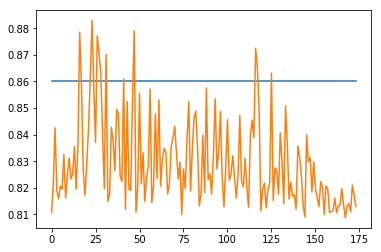

In [18]:
plot_result(a[:, 0], 0.86)

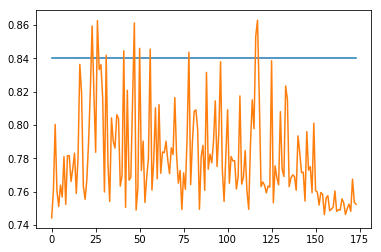

In [19]:
plot_result(a[:, 1], 0.84)

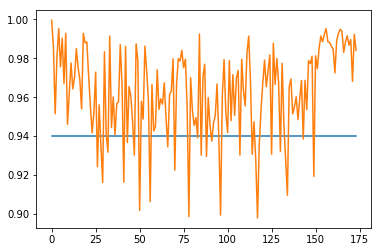

In [20]:
plot_result(a[:, 2], 0.94)

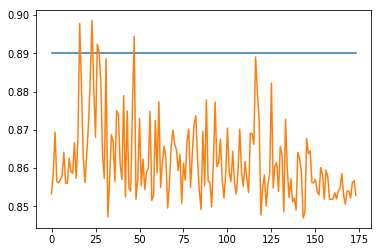

In [21]:
plot_result(a[:, 3], 0.89)